# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [1]:
import cv2
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "C:/Users/jackt/Desktop/CS445/cs445quilt/" 

#utilfn = datadir + "utils.py"
#!cp "$utilfn" .
#samplesfn = datadir + "samples"
#!cp -r "$samplesfn" .
import utils

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    im_out = np.full((out_size,out_size,3), 0)
    h_src = sample.shape[0]
    w_src = sample.shape[1]
    for i in range(0, out_size - patch_size + 1, patch_size):
        for j in range(0, out_size - patch_size + 1, patch_size):
            ry = np.random.randint(0, h_src - patch_size)
            rx = np.random.randint(0, w_src - patch_size)
            im_out[i:i+patch_size, j:j+patch_size] = sample[ry:ry+patch_size, rx:rx+patch_size]
    return im_out


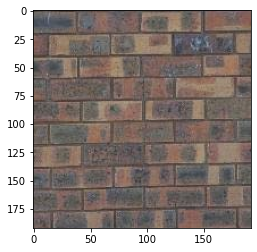

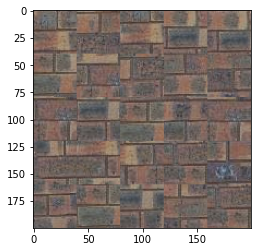

In [4]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 40
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [4]:
def ssd_patch(template, sample, patch_size, overlap, mode):
    """
    Computes the cost of sampling each patch based on the 
    SSD of the overlapping regions of the existing and patches of the image
    
    Assumes image is colored
    
    :param template: existing template
    :param sample: texture sample image
    :param x, y: top-left coordinates of next patch in existing image
    :param patch_size: patch size
    :param overlap: width of overlap region
    """
    # generate mask for left, top, or top-left overlap region
    mask = np.full((patch_size, patch_size, 3), 0)
    if mode == 0:
        # top
        mask[0:overlap,:,:] = 1
    elif mode == 1:
        # left
        mask[:,0:overlap,:] = 1
    elif mode == 2:
        # top-left
        mask[0:overlap,:,:] = 1
        mask[:,0:overlap,:] = 1
    else:
        mask[:,:,:] = 1
    # compute cost using SSD
    imsq = sample.astype(np.float64)**2
    ssd_cost = cv2.filter2D(imsq, ddepth=-1, kernel=mask[:,:,0]).sum(axis=2)
    
    mt = mask*template
    ssd_cost += (mt**2).sum()
    for c in range(3):
        s2 = cv2.filter2D(sample[:,:,c].astype(np.float64), ddepth=-1, kernel=mt[:,:,c])
        ssd_cost -= 2 * s2
    return ssd_cost

In [3]:
def choose_sample(cost_img, sample, phs, tol):
    ind = np.unravel_index(np.argsort(cost_img, axis=None), cost_img.shape)
    r = np.random.randint(0,tol)
    y = ind[0][r]
    x = ind[1][r]
    return sample[y:y+patch_size, x:x+patch_size]

In [7]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    im_out = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    step = patch_size - overlap
    num_patches = (out_size - patch_size + overlap) // step
    phs = patch_size // 2
    
    for r in range(0, num_patches):
        for c in range(0, num_patches):
            if r == 0 and c == 0:
                im_out[:patch_size, :patch_size] = sample[:patch_size, :patch_size]
            
            else:
                mode = 0
                if r == 0 and c > 0:
                    mode = 1
                elif r > 0 and c > 0:
                    mode = 2
                
                template = im_out[r*step:r*step+patch_size, c*step:c*step+patch_size]
                cost_img = ssd_patch(template, sample, patch_size, overlap, mode)
                im_out[r*step:r*step+patch_size, c*step:c*step+patch_size] = choose_sample(
                    cost_img[phs:-phs, phs:-phs], sample, patch_size, tol)
                    
    return im_out

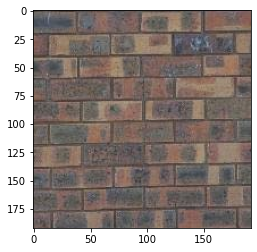

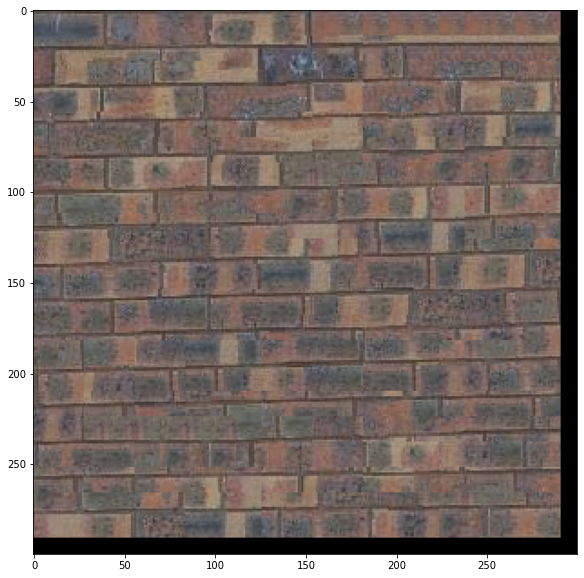

In [8]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [7]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to 
    create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    im_out = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    step = patch_size - overlap
    num_patches = (out_size - patch_size + overlap) // step
    phs = patch_size // 2
    
    for r in range(0, num_patches):
        for c in range(0, num_patches):
            if r == 0 and c == 0:
                im_out[:patch_size, :patch_size] = sample[:patch_size, :patch_size]
            
            else:
                mode = 0
                if r == 0 and c > 0:
                    mode = 1
                elif r > 0 and c > 0:
                    mode = 2
                
                template = im_out[r*step:r*step+patch_size, c*step:c*step+patch_size]
                cost_img = ssd_patch(template, sample, patch_size, overlap, mode)
                chosen = choose_sample(cost_img[phs:-phs, phs:-phs], sample, patch_size, tol)
                
                if r == 0 and c == 0:
                    im_out[r*step:r*step+patch_size, c*step:c*step+patch_size] = chosen
            
                elif r == 0 and c > 0:
                    diff = im_out[r*step:r*step+patch_size, c*step:c*step+overlap] - chosen[:patch_size,:overlap]
                    ssd = np.square(diff[:,:,0]) + np.square(diff[:,:,1]) + np.square(diff[:,:,2])

                    res_mask = cut(ssd.T).T
                    for y in range(0, patch_size):
                        for x in range(0, patch_size):
                            if x < overlap and res_mask[y,x] == 0:
                                continue
                            im_out[r*step+y, c*step+x] = chosen[y,x]
                            
                elif r > 0 and c == 0:
                    diff = im_out[r*step:r*step+overlap, c*step:c*step+patch_size] - chosen[:overlap,:patch_size]
                    ssd = np.square(diff[:,:,0]) + np.square(diff[:,:,1]) + np.square(diff[:,:,2])

                    res_mask = cut(ssd)
                    for y in range(0, patch_size):
                        for x in range(0, patch_size):
                            if y < overlap and res_mask[y,x] == 0:
                                continue
                            im_out[r*step+y, c*step+x] = chosen[y,x]
                            
                else:
                    diff_v = im_out[r*step:r*step+patch_size, c*step:c*step+overlap] - chosen[:patch_size,:overlap]
                    ssd_v = np.square(diff_v[:,:,0]) + np.square(diff_v[:,:,1]) + np.square(diff_v[:,:,2])
                    res_mask_v = cut(ssd_v.T).T
                    diff_h = im_out[r*step:r*step+overlap, c*step:c*step+patch_size] - chosen[:overlap,:patch_size]
                    ssd_h = np.square(diff_h[:,:,0]) + np.square(diff_h[:,:,1]) + np.square(diff_h[:,:,2])
                    res_mask_h = cut(ssd_h)
                    res_mask = np.ones((patch_size, patch_size), dtype="int")
                    res_mask[:,:overlap] = res_mask_v
                    res_mask[:overlap,:] = res_mask[:overlap,:] & res_mask_h
                    for y in range(0, patch_size):
                        for x in range(0, patch_size):
                            '''if y < overlap and res_mask_h[y,x] == 0:
                                continue # mask doesn't allow
                            if x < overlap and res_mask_v[y,x] == 0:
                                continue # mask doesn't allow
                            # otherwise add to output'''
                            if res_mask[y,x] != 0:
                                im_out[r*step+x, c*step+y] = chosen[x, y]
                            
                    
                    
    return im_out

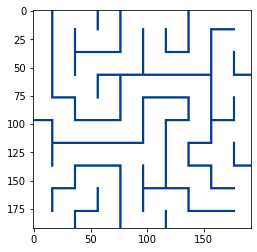

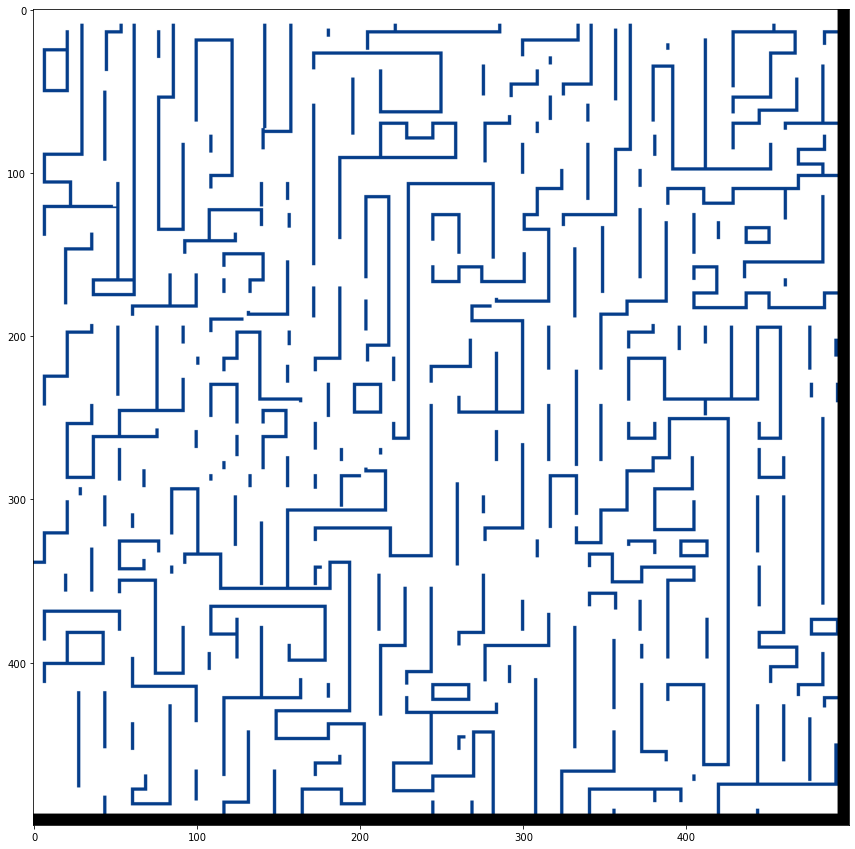

In [22]:
sample_img_fn = 'samples/maze.png' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 13
overlap = 5
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [14]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output 
    image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    im_out = np.zeros(guidance_im.shape, dtype=np.uint8)
    step = patch_size - overlap
    phs = patch_size // 2
        
    for row in range(0, guidance_im.shape[0] - patch_size + 1, step):
        for col in range(0, guidance_im.shape[1] - patch_size + 1, step):
            if row == 0 and col == 0:
                im_out[:patch_size, :patch_size] = sample[:patch_size, :patch_size]
            
            else:
                mode = 0
                if row == 0 and col > 0:
                    mode = 1
                elif row > 0 and col > 0:
                    mode = 2
                
                template = im_out[row:row+patch_size, col:col+patch_size]
                ssd_overlap  = ssd_patch(template, sample, patch_size, overlap, mode)
                guide_template = guidance_im[row:row+patch_size, col:col+patch_size]
                ssd_transfer = ssd_patch(guide_template, sample, patch_size, overlap, 3)
                cost_img = alpha * ssd_overlap + (1 - alpha) * ssd_transfer
                chosen = choose_sample(cost_img[phs:-phs, phs:-phs], sample, patch_size, tol)
                
                
                if row == 0 and col == 0:
                    im_out[row:row+patch_size, col:col+patch_size] = chosen
            
                elif row == 0 and col > 0:
                    diff = im_out[row:row+patch_size, col:col+overlap] - chosen[:patch_size,:overlap]
                    ssd = np.square(diff[:,:,0]) + np.square(diff[:,:,1]) + np.square(diff[:,:,2])

                    res_mask = cut(ssd.T).T
                    for y in range(0, patch_size):
                        for x in range(0, patch_size):
                            if x < overlap and res_mask[y,x] == 0:
                                continue
                            im_out[row+y, col+x] = chosen[y,x]
                            
                elif row > 0 and col == 0:
                    diff = im_out[row:row+overlap, col:col+patch_size] - chosen[:overlap,:patch_size]
                    ssd = np.square(diff[:,:,0]) + np.square(diff[:,:,1]) + np.square(diff[:,:,2])

                    res_mask = cut(ssd)
                    for y in range(0, patch_size):
                        for x in range(0, patch_size):
                            if y < overlap and res_mask[y,x] == 0:
                                continue
                            im_out[row+y, col+x] = chosen[y,x]
                            
                else:
                    diff_v = im_out[row:row+patch_size, col:col+overlap] - chosen[:patch_size,:overlap]
                    ssd_v = np.square(diff_v[:,:,0]) + np.square(diff_v[:,:,1]) + np.square(diff_v[:,:,2])
                    res_mask_v = cut(ssd_v.T).T
                    diff_h = im_out[row:row+overlap, col:col+patch_size] - chosen[:overlap,:patch_size]
                    ssd_h = np.square(diff_h[:,:,0]) + np.square(diff_h[:,:,1]) + np.square(diff_h[:,:,2])
                    res_mask_h = cut(ssd_h)
                    for y in range(0, patch_size):
                        for x in range(0, patch_size):
                            if y < overlap and res_mask_h[y,x] == 0:
                                continue # mask doesn't allow
                            if x < overlap and res_mask_v[y,x] == 0:
                                continue # mask doesn't allow
                            # otherwise add to output
                            im_out[row+x, col+y] = chosen[x, y]
                    
    return im_out

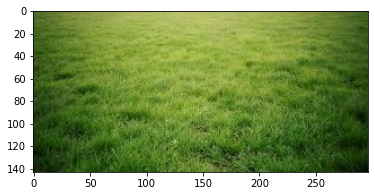

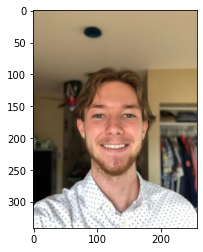

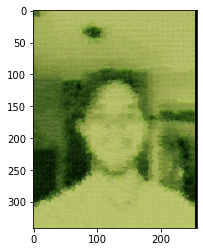

In [17]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/lawn.jpg' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()

guidance_img_fn = 'samples/profile.jpg' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()

patch_size = 13
overlap = 5
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.imshow(res)
plt.show()